Get Data from Kaggle API

In [1]:
!pip install tensorflow

Imports

In [2]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Data Loading Preprocessing

In [3]:
path = '../chest_xray/'


# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])

for x in train_pneu_cases:
    train_list.append([x, 1])

for x in test_normal_cases:
    test_list.append([x, 0])

for x in test_pneu_cases:
    test_list.append([x, 1])

for x in val_normal_cases:
    val_list.append([x, 0])

for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

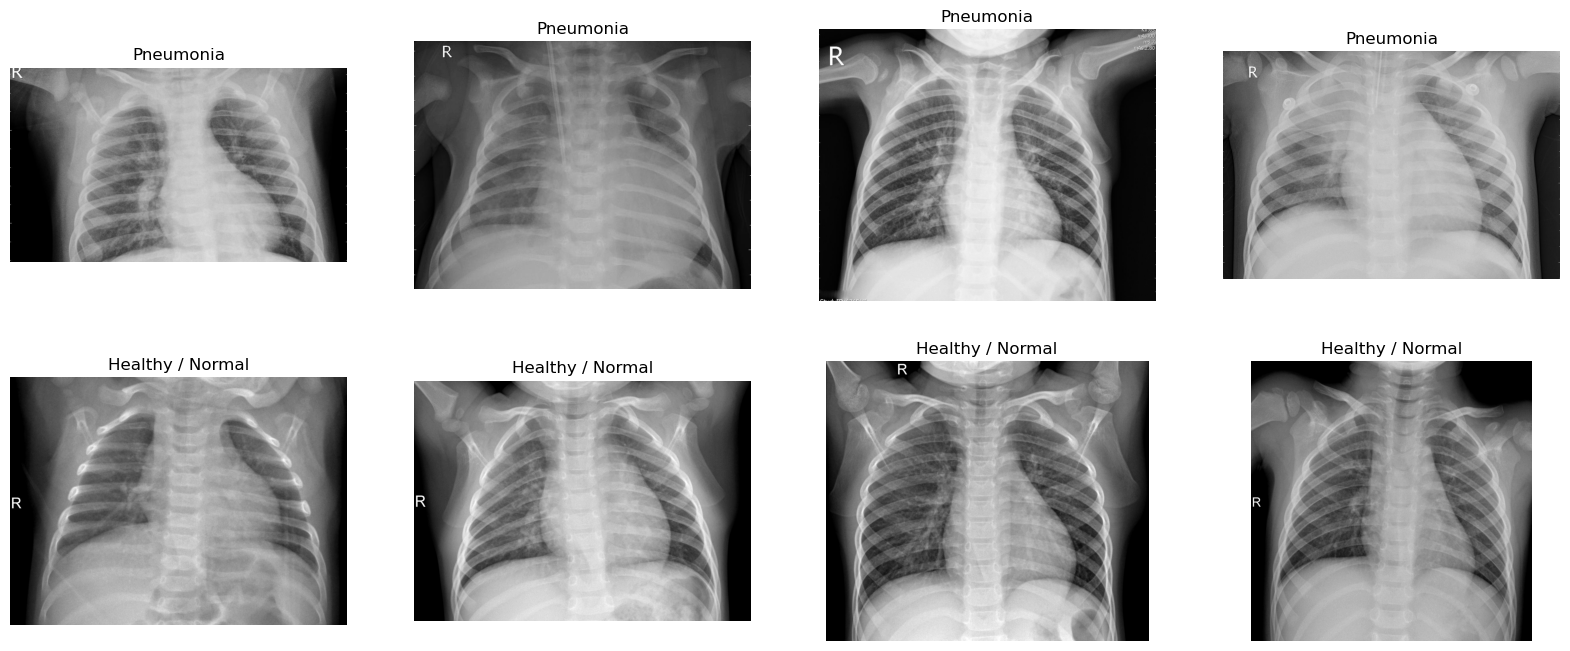

In [4]:
#plot some samples
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

In [5]:
# data preprocessing/ final loading and formatting
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))

    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)

    return np.array(data), np.array(labels)

Using our functions let's prepare our train, test and validation arrays from dataframes

In [6]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


**Image augmentation**

In [7]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

It may be redudant step, but we are going to convert our 1D array of target labels into 2D array, changing classification from binary to categorical. During my tests, binary classification was slower and less accurate then categorical.

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Modelling

This Model is slower, but getting above 92% accuracy compared to previous based model.

In [9]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

In [10]:
from tensorflow.keras.optimizers.legacy import Adam

In [11]:
with tf.device('/GPU:0'):  # specifying to use the first GPU
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
    model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 8)       400       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 8)       3144      
                                                                 
 max_pooling2d (MaxPooling2  (None, 65, 65, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 65, 16)        3216      
                                                                 
 conv2d_3 (Conv2D)           (None, 65, 65, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 16)        0         
 g2D)                                                   

In [12]:
callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_val, y_val), epochs = 10, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/10
1304/1304 [==============================] - 120s 92ms/step - loss: 0.6662 - accuracy: 0.4979 - val_loss: 1.0496 - val_accuracy: 0.6250
Epoch 2/10
1304/1304 [==============================] - 122s 93ms/step - loss: 0.2931 - accuracy: 0.8637 - val_loss: 0.6796 - val_accuracy: 0.8125
Epoch 3/10
1304/1304 [==============================] - 121s 93ms/step - loss: 0.2622 - accuracy: 0.8813 - val_loss: 0.4174 - val_accuracy: 0.8125
Epoch 4/10
1304/1304 [==============================] - 122s 94ms/step - loss: 0.2294 - accuracy: 0.8934 - val_loss: 0.4750 - val_accuracy: 0.8125
Epoch 5/10
1304/1304 [==============================] - 123s 94ms/step - loss: 0.2065 - accuracy: 0.8978 - val_loss: 0.4480 - val_accuracy: 0.8750
Epoch 6/10
1304/1304 [==============================] - 121s 93ms/step - loss: 0.2139 - accuracy: 0.9038 - val_loss: 0.4135 - val_accuracy: 0.8750
Epoch 7/10
1304/1304 [==============================] - 123s 94ms/step - loss: 0.2056 - accuracy: 0.8982 - val_loss: 0

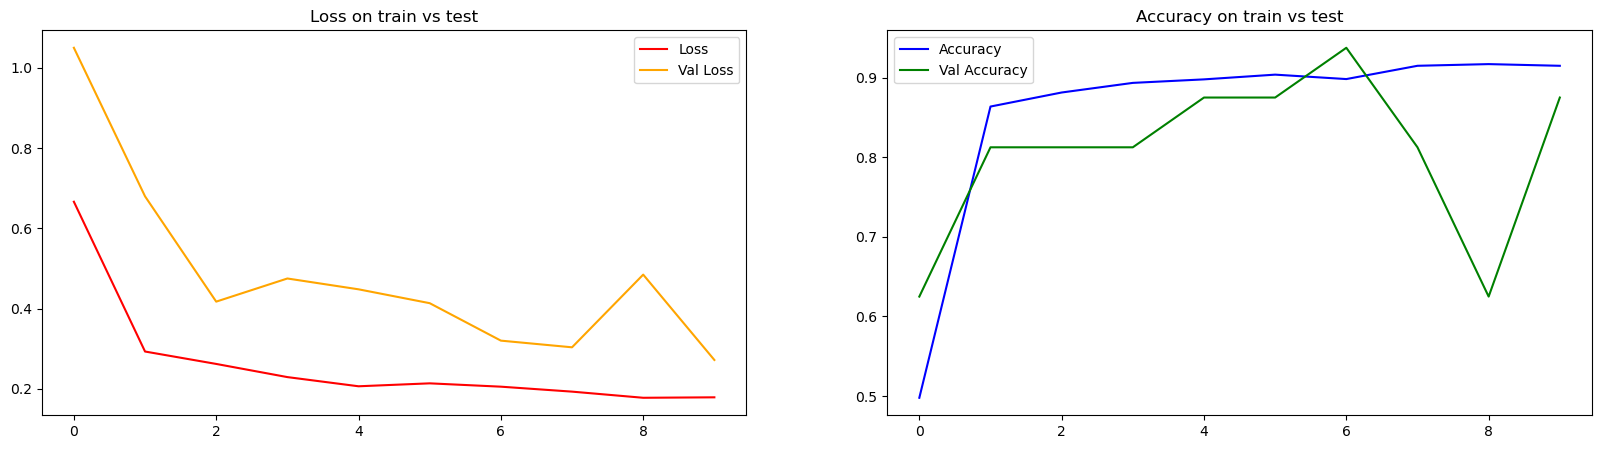

In [13]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

# Evaluation


In [14]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

156/156 [==============================] - 3s 17ms/step


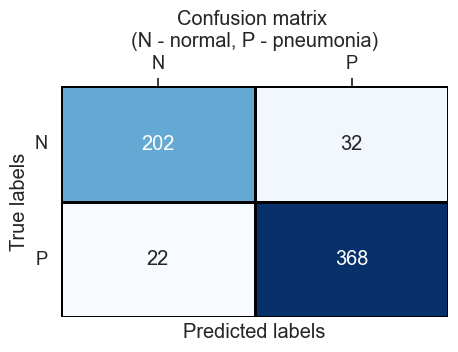

Classification report on test data
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       234
           1       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



In [15]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['N', 'P'], yticklabels=['N', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top')
plt.title('Confusion matrix \n(N - normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

Visulise X-rays with the predictions

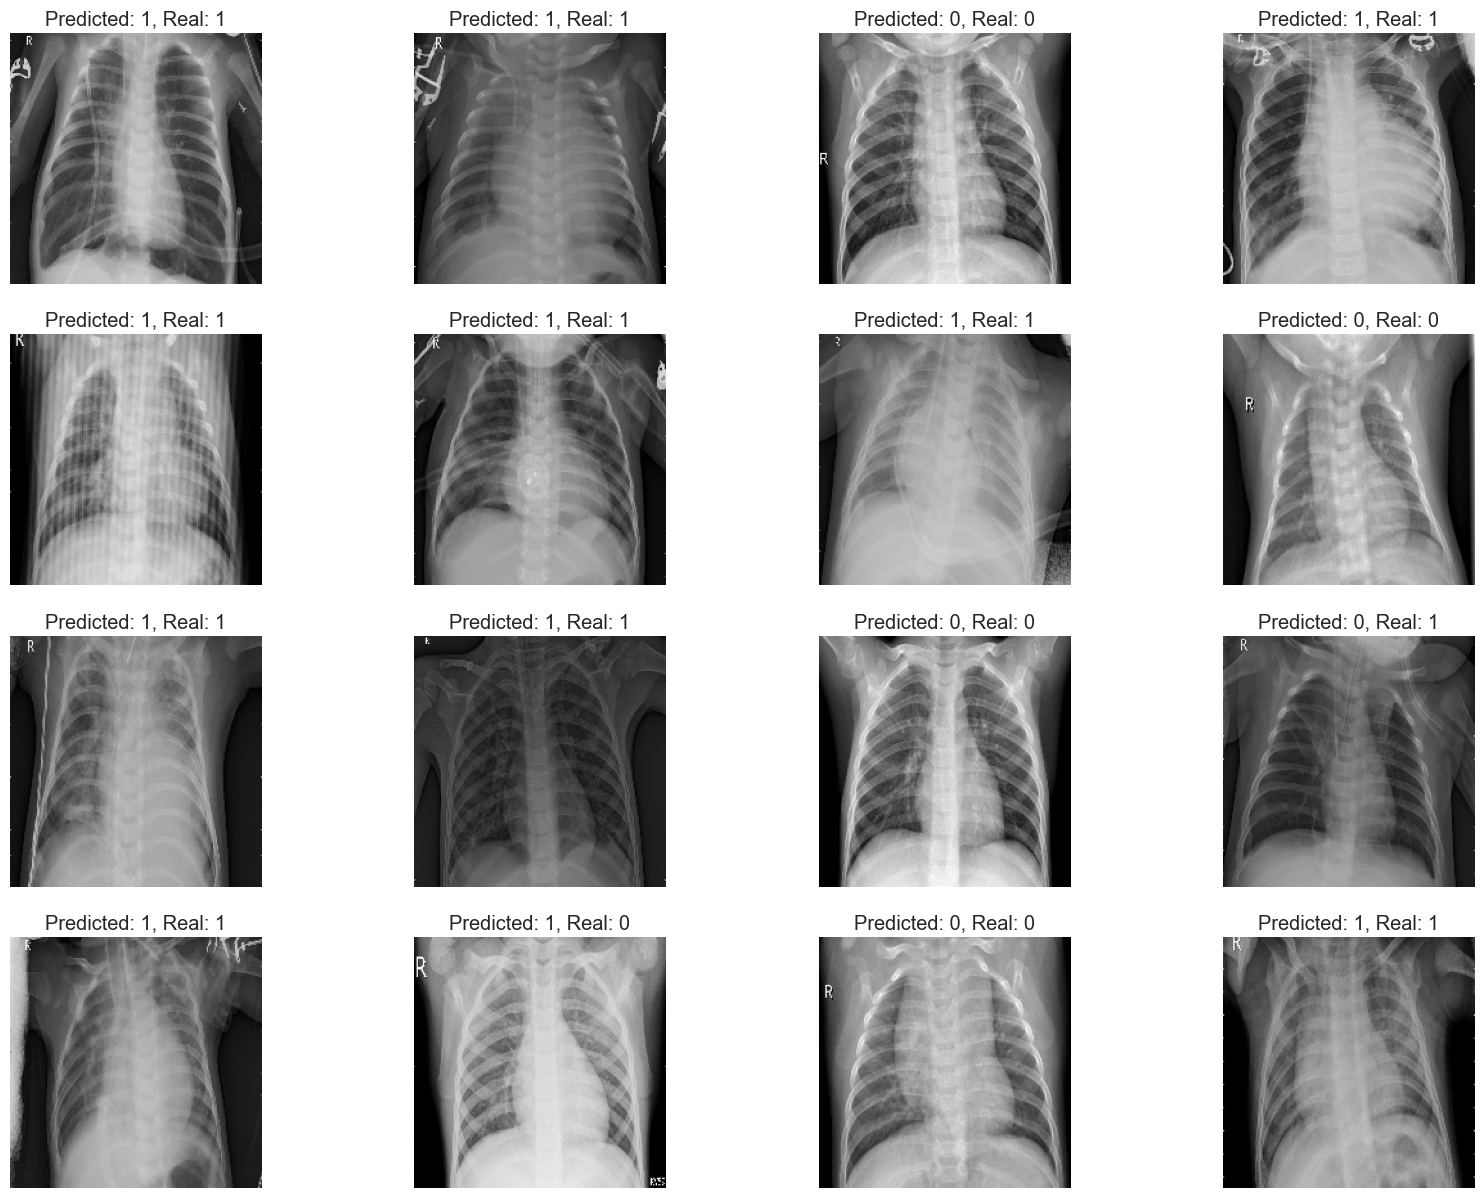

In [16]:
# plt.figure(figsize=(20, 15))
# for i in range(16):  # limit to first 16 samples
#     plt.subplot(4, 4, i+1)
#     plt.imshow(X_test[i].reshape(196, 196), cmap='gray')
#     plt.axis('off')
#     plt.title('Predicted: {}, Real: {}'.format(y_test_hat[i], y_test[i]))


SAVE MODEL

In [17]:
 model.save('new_model.h5')

Save_preprocessing parameters

In [18]:
# import json

# config = {
#     'image_size': 196,
#     'color_mode': 'grayscale',
#     'normalization_factor': 255.0,
# }

# with open('preprocess_config.json', 'w') as f:
#     json.dump(config, f)


**Load the Model and Preprocessing Details for Future Predictions:**

When you want to make predictions in the future, you can load the model and the preprocessing configuration as follows:

In [19]:
# from tensorflow.keras.models import load_model
# import json
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt


# # Load the model
# model = load_model('new_model.h5')

# # Load the preprocessing details
# with open('preprocess_config.json', 'r') as f:
#     config = json.load(f)

# image_size = config['image_size']
# normalization_factor = config['normalization_factor']

# # Example of how to use the loaded model and config for prediction
# def preprocess_image(img_path):
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (image_size, image_size))
#     img = img / normalization_factor
#     img = np.reshape(img, (image_size, image_size, 1))
#     return img

# def predict(img_path):
#     img = preprocess_image(img_path)
#     img = np.expand_dims(img, axis=0)  # Add batch dimension
#     prediction = model.predict(img)[0]

#     predicted_class = 'Pneumonia' if prediction[1] > prediction[0] else 'Normal'
#     probability = max(prediction)

#     return predicted_class, probability


In [20]:

# # Example usage
# img_path = '/content/chest_xray/test/NORMAL/IM-0009-0001.jpeg'
# predicted_class, probability = predict(img_path)

# # Load the image for visualization
# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# # Display the image with the prediction in the title
# plt.imshow(img, cmap='gray')
# plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}')
# plt.axis('off')  # Hide axes
# plt.show()

# print('Predicted Class:', predicted_class)
# print('Probability:', probability)
